In [1]:
import numpy as np
import pandas as pd

import os
import random

import warnings

warnings.filterwarnings(action='ignore')

path = '/opt/ml/input/data/'
dat = pd.read_csv(path + '/FE/FE_total.csv')

In [2]:
##### label encodig
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(dat['assessmentItemID'])
dat['assessmentItemID'] = encoder.transform(dat['assessmentItemID'])

encoder.fit(dat['category_st_qcut_5'])
dat['category_st_qcut_5'] = encoder.transform(dat['category_st_qcut_5'])

encoder.fit(dat['testId'])
dat['testId'] = encoder.transform(dat['testId'])

dat

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solve_time,b_category,test_category,problem_id,category_st_qcut_5
0,0,5354,975,1,2020-03-24 00:17:11,7224,0,6,1,1,0
1,0,5355,975,1,2020-03-24 00:17:14,7225,3,6,1,2,2
2,0,5356,975,1,2020-03-24 00:17:22,7225,8,6,1,3,2
3,0,5357,975,1,2020-03-24 00:17:29,7225,7,6,1,4,2
4,0,5358,975,1,2020-03-24 00:17:36,7225,7,6,1,5,2
...,...,...,...,...,...,...,...,...,...,...,...
2526695,7441,2373,456,0,2020-06-05 06:50:21,438,24,3,71,5,1
2526696,7441,3909,748,1,2020-08-21 01:06:39,8836,0,4,165,1,0
2526697,7441,3910,748,1,2020-08-21 01:06:50,8836,11,4,165,2,2
2526698,7441,3911,748,1,2020-08-21 01:07:36,8836,46,4,165,3,3


In [3]:
_train = dat[dat['answerCode'] >= 0]
_test = dat[dat['answerCode'] < 0]

In [4]:
# 유저 마다 가장 마지막 문제를 맞추는 것을 기준으로 평가 하려함
# test 유저에 경우 가장 마지막 문제 전 문제를 맞추는 것을 기준으로 평가함.
user_final_time = _train.groupby('userID')['Timestamp'].max()
_train['train_valid'] = _train.apply(lambda x : -1 if x.Timestamp == user_final_time[x.userID] else x['answerCode'], axis = 1)
_valid = _train[_train['train_valid'] < 0]
_train = _train[_train['train_valid'] >= 0]

In [5]:
# 모델에 적용하기 전 기본적인 데이터 전처리 부분
## 라벨링, 필요없는 칼럼 제거
_train_value = _train['answerCode']
_train.drop(['Timestamp', 'train_valid', 'answerCode'], axis = 1, inplace = True)

_valid_value = _valid['answerCode']
_valid.drop(['Timestamp', 'train_valid', 'answerCode'], axis = 1, inplace = True)

_test.drop(['Timestamp', 'answerCode'], axis = 1, inplace = True)

In [6]:
_train

,userID,assessmentItemID,testId,KnowledgeTag,solve_time,b_category,test_category,problem_id,category_st_qcut_5
0,0,5354,975,7224,0,6,1,1,0
1,0,5355,975,7225,3,6,1,2,2
2,0,5356,975,7225,8,6,1,3,2
3,0,5357,975,7225,7,6,1,4,2
4,0,5358,975,7225,7,6,1,5,2
...,...,...,...,...,...,...,...,...,...
2526694,7441,2372,456,438,34,3,71,4,3
2526695,7441,2373,456,438,24,3,71,5,1
2526696,7441,3909,748,8836,0,4,165,1,0
2526697,7441,3910,748,8836,11,4,165,2,2


In [8]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(learning_rate=0.02,n_estimators = 1000,max_depth=9)
xgb_model.fit(_train, _train_value ,verbose=500,early_stopping_rounds=100, eval_metric='auc',eval_set=[(_valid, _valid_value)])

[0]	validation_0-auc:0.70175
[500]	validation_0-auc:0.76701
[999]	validation_0-auc:0.78280


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [9]:
# valid score를 확인해봄.
# 모델 환경상 test score보다 떨어질 수도. (토론 필요)
# 실제 제출한 test score은 auc는 0.7864, acc는 0.7124
from sklearn.metrics import accuracy_score, roc_auc_score

_valid_pred = xgb_model.predict_proba(_valid)[:,1]
print(roc_auc_score(_valid_value, _valid_pred)) # auc
print(accuracy_score(_valid_value, np.where(_valid_pred >= 0.5, 1, 0))) # acc, 정확도

0.7828015498887939
0.6995373430270985


Text(0.5, 1.0, 'Feature Importance')

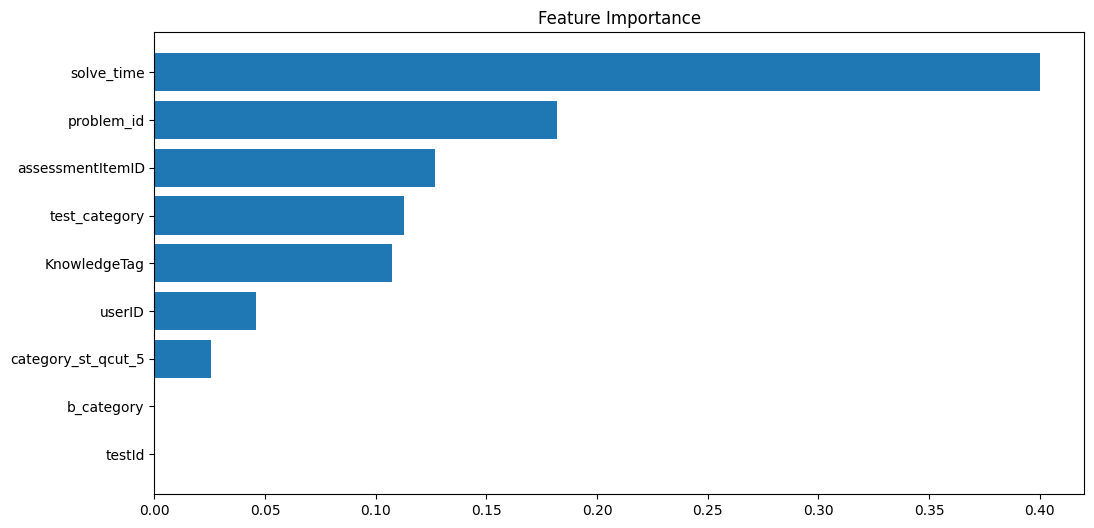

In [10]:
import matplotlib.pyplot as plt

feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(_valid.columns)[sorted_idx])
plt.title("Feature Importance")

In [11]:
# submission 제출하기 위한 코드
_test_pred = xgb_model.predict_proba(_test)[:,1]
_test['prediction'] = _test_pred
submission = _test['prediction'].reset_index(drop = True).reset_index()
submission.rename(columns = {'index':'id'}, inplace = True)
submission.to_csv('./output/xg_submission.csv', index = False)